In [2]:
from typing import Any
from distributed import Client
from src.logging_utils.logger import logger
import os
from sklearn.pipeline import Pipeline
from src.pipeline.caching.tif import CacheTIFPipeline
from src.pipeline.model.feature.column.get_columns import get_columns
from src.pipeline.model.feature.error import FeaturePipelineError
from src.pipeline.model.feature.transformation.get_transformations import get_transformations
from joblib import hash
from rasterio.plot import show
from src.pipeline.model.feature.feature import FeaturePipeline
import numpy as np
from dask_image.imread import imread
import rasterio
import glob
import dask

In [ ]:
# Example test
raw_data_path = "data/raw/train_satellite"
target_path = "data/raw/train_kelp"
processed_path = "data/processed"
features_path = "data/features"
transform_steps = []
columns: list[dict[str, Any]] = []

client = Client()
import time
orig_time = time.time()
# Create the feature pipeline
# Parse the raw data
orig_time = time.time()
images = imread(f"{raw_data_path}/*.tif")
print(time.time() - orig_time)
labels = imread(f"{target_path}/*.tif")
print(images.shape)
print(labels.shape)
client.close()

In [6]:
import torch
from src.pipeline.model.model_loop.model_fit_block import Dask2TorchDataset

In [7]:
dataset = Dask2TorchDataset(images, labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

In [ ]:
# loop over the dataloader and print the type of each object
client = Client(n_workers=6, threads_per_worker=1, memory_limit='2GB')
for i, (X,y) in enumerate(dataloader):
    print(X.shape, y.shape)
    if i > 10:
        break

In [86]:
# using rasterio read the tiff files in to a numpy array
# make the eading in to a dask delayed function
import glob
import toolz
import dask
import dask.array as da
import torch
from torchvision import transforms
from PIL import Image

@dask.delayed
def read_image(path):
    image = np.array(rasterio.open(path).read())
    return image
# images = np.array([rasterio.open(file).read() for file in glob.glob(f"{raw_data_path}/*.tif")])
@dask.delayed
def transform(img):
    tensor = torch.from_numpy(img)
    tensor = tensor.float()
    
    return tensor


In [87]:
objs = [read_image(x) for x in glob.glob(f"{raw_data_path}/*.tif")]

In [88]:
tensors = [transform(x) for x in objs]

In [89]:
batches = [dask.delayed(torch.stack)(batch)
           for batch in toolz.partition_all(10, tensors)]

In [94]:
# make a simple conv layer that takes 350x350 images and returns a 1x1 tensor

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(7, 1, 3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x
    
model = ConvNet()
dmodel = dask.delayed(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [95]:
@dask.delayed
def predict(batch, dmodel):
    with torch.no_grad():
        out = dmodel(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

In [96]:
predictions = [predict(batch, model) for batch in batches]

In [97]:
predictions = dask.compute(*predictions)

In [99]:
print(predictions[0].shape)

(10, 350, 350)


In [14]:
for i in range(images.shape[3]):
    channel_images = images[:, :, :, i]
    # now flatten channel images to 1d
    channel_images = channel_images.reshape(
        (1,-1))
    channel_images = channel_images.rechunk({1127: channel_images.shape[1]})
    # now fit a standard scaler to the channel images
    scaler = StandardScaler()
    scaler.fit(channel_images)


Task exception was never retrieved
future: <Task finished name='Task-315052' coro=<Client._gather.<locals>.wait() done, defined at c:\Users\Tolga\Desktop\EPOCH-IV\q2-detect-kelp\.venv\Lib\site-packages\distributed\client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "c:\Users\Tolga\Desktop\EPOCH-IV\q2-detect-kelp\.venv\Lib\site-packages\distributed\client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-315051' coro=<Client._gather.<locals>.wait() done, defined at c:\Users\Tolga\Desktop\EPOCH-IV\q2-detect-kelp\.venv\Lib\site-packages\distributed\client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "c:\Users\Tolga\Desktop\EPOCH-IV\q2-detect-kelp\.venv\Lib\site-packages\distributed\client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-315050' coro=<Client.

KeyboardInterrupt: 

In [ ]:
# now compare the standard scaler to torch layernorm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Layer norm result on a single channel
-0.7301748
3.457006


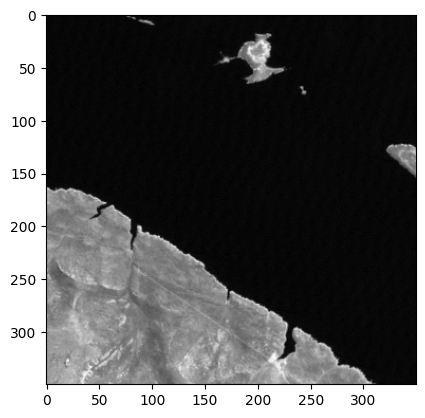

In [ ]:
# create a torch tensor from the flattened images
torch_image = torch.tensor(images[0].compute()[channel],dtype=torch.float32)
# create a layer norm layer
layer_norm = nn.LayerNorm([350,350]).to('cpu', dtype=torch.float32)
layer_norm_images = layer_norm(torch_image)
# show the resulting image 
print('Layer norm result on a single channel')
print(layer_norm_images.detach().numpy().min())
print(layer_norm_images.detach().numpy().max())
plt.imshow(layer_norm_images.detach().numpy(), cmap='gray')
plt.show()
